In [42]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
sys.path.append("..")
#sys.path.append("~/sql_representation/")

from db_utils.utils import *
from db_utils.query_storage import *
from utils.utils import *

#from cardinality_estimation.featurizer import Featurizer
#from query_representation.query import load_qrep
#from cardinality_estimation.dataset import *
from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt
import networkx as nx

flow loss C library not being used
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [245]:

#TESTDIR = os.path.join(os.path.join("..", "queries"), "imdb-unique-plans")
#RESULTDIR = os.path.join("..", "results")
#make_dir(RESULTDIR)

TRAINDIR = os.path.join(os.path.join("/Users/pari/MyCEB", "queries"), "imdb-unique-plans")
RTDIRS = ["/Users/pari/prism-testbed/final_results/CEB/1gb-cache0/", 
          "/Users/pari/prism-testbed/final_results/CEB/ablation/",
          "/Users/pari/prism-testbed/final_results/data_updates/CEB/",
          "/Users/pari/prism-testbed/final_results/FCNN/all/"]

# TRAINDIR = os.path.join(os.path.join("/Users/pari/MyCEB", "queries"), "job")
# RTDIR = "/Users/pari/prism-testbed/final_results/JOB/ablation/"
#RTFN = "/Users/pari/prism-testbed/final_results/CEB/1gb-cache0/Postgres/Runtimes.csv"

In [246]:
#G = explain_to_nx(data[0][0][0])

In [247]:
#G.nodes()

In [248]:
rtdfs = []

for RTDIR in RTDIRS:    
    rdirs = os.listdir(RTDIR)
    for rd in rdirs:
        rtfn = os.path.join(RTDIR, rd, "Runtimes.csv")
        if os.path.exists(rtfn):
            rtdfs.append(pd.read_csv(rtfn))

In [249]:
rtdf = pd.concat(rtdfs)

# Query loading helper functions

In [250]:
def load_qrep(fn):
    assert ".pkl" in fn
    try:
        with open(fn, "rb") as f:
            query = pickle.load(f)
    except:
        print(fn + " failed to load...")
        exit(-1)

    query["subset_graph"] = \
            nx.OrderedDiGraph(json_graph.adjacency_graph(query["subset_graph"]))
    query["join_graph"] = json_graph.adjacency_graph(query["join_graph"])
    if "subset_graph_paths" in query:
        query["subset_graph_paths"] = \
                nx.OrderedDiGraph(json_graph.adjacency_graph(query["subset_graph_paths"]))

    return query


def load_qdata(fns):
    qreps = []
    for qfn in fns:
        qrep = load_qrep(qfn)
        #qrep = load_sql_qrep(qfn)
        # TODO: can do checks like no queries with zero cardinalities etc.
        qreps.append(qrep)
        template_name = os.path.basename(os.path.dirname(qfn))
        qrep["name"] = os.path.basename(qfn)
        qrep["template_name"] = template_name
    return qreps

def get_query_fns(basedir, template_fraction=1.0, sel_templates=None):
    fns = []
    tmpnames = list(glob.glob(os.path.join(basedir, "*")))
    print(tmpnames)
    assert template_fraction <= 1.0
    
    for qi,qdir in enumerate(tmpnames):
        if os.path.isfile(qdir):
            print(qdir)
            continue
        template_name = os.path.basename(qdir)
        if sel_templates is not None and template_name not in sel_templates:
            continue
        
        # let's first select all the qfns we are going to load
        qfns = list(glob.glob(os.path.join(qdir, "*.pkl")))
        qfns.sort()
        num_samples = max(int(len(qfns)*template_fraction), 1)
        random.seed(1234)
        qfns = random.sample(qfns, num_samples)
        fns += qfns
    return fns

# Evaluation helper functions

In [251]:
def omega_approx(beta):
    """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
    return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma

# find tau star hat when sigma is unknown
# tau = svht(D, sv=sv)

# # find tau star when sigma is known
# tau = svht(D, sigma=0.5)

# Load queries

In [252]:
# set template_fraction <= 1.0 to test quickly w/ smaller datasets
# train_qfns = get_query_fns(TRAINDIR, template_fraction = 0.001)
# val_qfns = get_query_fns(VALDIR, template_fraction = 1.0)
# test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0)

#qfns = get_query_fns(TRAINDIR, template_fraction = 1.0, sel_templates=None)

qfns = get_query_fns(TRAINDIR, template_fraction = 1.0, sel_templates=None)
print(len(qfns))
qdata = load_qdata(qfns)

['/Users/pari/MyCEB/queries/imdb-unique-plans/3b', '/Users/pari/MyCEB/queries/imdb-unique-plans/9b', '/Users/pari/MyCEB/queries/imdb-unique-plans/6a', '/Users/pari/MyCEB/queries/imdb-unique-plans/5a', '/Users/pari/MyCEB/queries/imdb-unique-plans/11a', '/Users/pari/MyCEB/queries/imdb-unique-plans/1a', '/Users/pari/MyCEB/queries/imdb-unique-plans/8a', '/Users/pari/MyCEB/queries/imdb-unique-plans/2a', '/Users/pari/MyCEB/queries/imdb-unique-plans/9a', '/Users/pari/MyCEB/queries/imdb-unique-plans/3a', '/Users/pari/MyCEB/queries/imdb-unique-plans/10a', '/Users/pari/MyCEB/queries/imdb-unique-plans/dbdata.json', '/Users/pari/MyCEB/queries/imdb-unique-plans/2c', '/Users/pari/MyCEB/queries/imdb-unique-plans/4a', '/Users/pari/MyCEB/queries/imdb-unique-plans/11b', '/Users/pari/MyCEB/queries/imdb-unique-plans/2b', '/Users/pari/MyCEB/queries/imdb-unique-plans/7a']
/Users/pari/MyCEB/queries/imdb-unique-plans/dbdata.json
3133


In [266]:
from collections import defaultdict
import numpy

subplan_data = defaultdict(list)

rowkeys = set()

cur_exps = []

qid = 0
newqs = {}

for qi, qrep in enumerate(qdata):
    for node in qrep["subset_graph"].nodes():
        rowkeys.add(node)
        
    tmp = rtdf[rtdf["qname"] == qrep["name"]]
    
    if len(tmp) != 0:
        for explain in tmp["exp_analyze"].values:
            newqs[len(cur_exps)] = qid
            cur_exps.append(explain)
        qid += 1
    
rowkeys = list(rowkeys)
rowkeys.sort()
rowidxs = {rk:ri for ri,rk in enumerate(rowkeys)}

# mat = np.zeros((len(rowidxs), len(qdata)))

# for qi, qrep in enumerate(qdata):
#     for node in qrep["subset_graph"].nodes():
#         truec = qrep["subset_graph"].nodes()[node]["cardinality"]["actual"]
#         mat[rowidxs[node], qi] = truec
        
# mat = mat.T

In [267]:
rtdf

,qname,runtime,exp_analyze
0,68d8bd42c6041022ccdbd830309a7676c66f9e5b.pkl,44.081961,"[([{'Plan': {'Node Type': 'Aggregate', 'Strate..."
1,2b248.pkl,11.693408,"[([{'Plan': {'Node Type': 'Aggregate', 'Strate..."
2,2a828.pkl,16.728585,"[([{'Plan': {'Node Type': 'Aggregate', 'Strate..."
3,2b279.pkl,13.723778,"[([{'Plan': {'Node Type': 'Aggregate', 'Strate..."
4,1a1130.pkl,7.577718,"[([{'Plan': {'Node Type': 'Aggregate', 'Strate..."
...,...,...,...
108,23a.pkl,3.908659,"[([{'Plan': {'Node Type': 'Aggregate', 'Strate..."
109,18a.pkl,6.445714,"[([{'Plan': {'Node Type': 'Aggregate', 'Strate..."
110,2d.pkl,4.485744,"[([{'Plan': {'Node Type': 'Aggregate', 'Strate..."
111,10b.pkl,4.893731,"[([{'Plan': {'Node Type': 'Aggregate', 'Strate..."


In [268]:

rtmat = np.zeros((len(rowidxs), qid))
print(rtmat.shape)

for ei, exp in enumerate(cur_exps):
    try:
        exp = eval(exp)
    except:
        continue
        
    G = explain_to_nx(exp)
    cur_qid = newqs[ei]
    for node,ndata in G.nodes(data=True):
        cal = ndata["aliases"]
        cal.sort()
        #print(tuple(cal) in rowkeys)
        #rt = ndata["cur_time"]
        rt = ndata["total_time"]
        rtmat[rowidxs[tuple(cal)], cur_qid] = rt
        
rtmat = rtmat[~np.all(rtmat == 0, axis=1)]

(4601, 509)


In [269]:
rtmat.shape

(1654, 509)

In [270]:
nz = np.count_nonzero(rtmat)
tot = rtmat.shape[0]*rtmat.shape[1]
print("Non Zero Fraction: ", nz / tot)

Non Zero Fraction:  0.040403332517704296


In [271]:
P, S, Q = np.linalg.svd(rtmat, full_matrices=False)
print(S.shape)
print(S.round(2))

(509,)
[1.01592174e+07 9.00160857e+06 4.90893358e+06 4.62056071e+06
 3.77163450e+06 3.71786919e+06 3.63496288e+06 3.19942351e+06
 3.15835543e+06 2.79578898e+06 2.55959702e+06 2.51941712e+06
 2.39839262e+06 2.26492260e+06 2.16865087e+06 1.99982487e+06
 1.90680718e+06 1.83580904e+06 1.75254706e+06 1.51458447e+06
 1.50213903e+06 1.47965763e+06 1.44871811e+06 1.41295235e+06
 1.33897436e+06 1.29398851e+06 1.28162696e+06 1.26345177e+06
 1.24397436e+06 1.22492950e+06 1.13302091e+06 1.10675848e+06
 1.08008061e+06 1.04493092e+06 1.03811483e+06 9.83059660e+05
 9.62025810e+05 9.20655860e+05 8.95035680e+05 8.86810040e+05
 8.80635750e+05 7.97161830e+05 7.24760680e+05 7.20406620e+05
 6.94416180e+05 6.91516040e+05 6.86789060e+05 6.61065820e+05
 6.52173440e+05 6.24199090e+05 6.21307760e+05 6.09597140e+05
 6.03242770e+05 5.93284820e+05 5.89626370e+05 5.74313320e+05
 5.61722940e+05 5.37510190e+05 5.31731440e+05 5.19586850e+05
 5.03127550e+05 5.00964990e+05 4.97155650e+05 4.90018890e+05
 4.81506450e+05 4

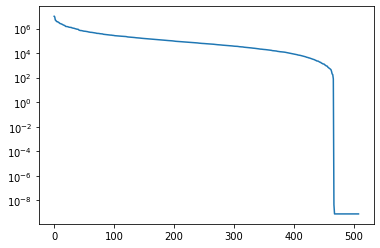

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt

#sns.lineplot(np.log(S))
#sns.lineplot(y=S)
plt.plot(S)
plt.yscale("log")
plt.show()

In [273]:
cds = np.cumsum(S) / np.sum(S)
r90 = np.min(np.where(cds > 0.90))
print("90% explained by: ", r90)

tau = svht(mat, sv=S)
rank = np.sum(S > tau)
print("Noise cut-off: ", rank)

90% explained by:  151
Noise cut-off:  197
